In [1]:
import pandas as pd
import networkx as nx
import pandas as pd
import matplotlib_venn as pltv
import pickle
import os
import graphlot as gr
import biomapy as bp
from collections import Counter
import pronto
from nxontology.imports import pronto_to_multidigraph

# 1. INTEGRATING LAST VERSION OF HUMAN REFERENCE 8

In [2]:
huri = pd.read_csv('../datasets/huri_last.csv')
huri = huri[['source_entrez','target_entrez']]
ppi=pd.read_csv('../datasets/multiscale-interactome/3_protein_to_protein.tsv',sep='\t')

huri = huri.astype(str)
ppi.node_1=ppi.node_1.astype(str)
ppi.node_2=ppi.node_2.astype(str)
print(f'total interactions in multiscale interactome {ppi.shape[0]}')
ppi = ppi[['node_1','node_2']]
ppi.columns = ['source_entrez','target_entrez']
ppi = ppi._append(huri)

print(f'total interactions in multiscale + Huri {ppi.shape[0]}')

ppi = ppi.drop_duplicates()

print(f'total *UNIQUE* interactions in multiscale + Huri {ppi.astype(str).shape[0]}')


total interactions in multiscale interactome 387626
total interactions in multiscale + Huri 439609
total *UNIQUE* interactions in multiscale + Huri 435678


# 2.CHECK GDA OVERLAPPING BETWEEN HPO AND DISGENET

In [3]:
### READ HPO

hp_obo=pronto.Ontology('../datasets/hp.obo')
hp_multidigraph = pronto_to_multidigraph(hp_obo)
print(f"""
        Type and number of relationship in HPO: {Counter(key for _, _, key in hp_multidigraph.edges(keys=True))} 
        
        
        Number of phenotypes in HPO: {len(hp_multidigraph.nodes())}""")

#CREATE THE EDGELIST

hp_edgelist=pd.DataFrame([(source,rel,target) for (source,rel,target) in hp_multidigraph.edges(keys=True)],columns=['source','target','relation'])

# BUILD A MAPPER BETWEEN NAME AND HP NAME
hpid_to_name = {id_: data.get('name') for id_, data in hp_multidigraph.nodes(data=True)}
name_to_hpid= {v:k for k,v in hpid_to_name.items()}

# INSERT A SLASH BETWEEN IS A RELATIONSHIP
hp_edgelist.relation=hp_edgelist.relation.apply(lambda x: x.replace(' ','_'))

hpcuimapper=pd.read_csv('../datasets/MedGen_HPO_Mapping.txt',sep='|')
hpcuimapgroup=hpcuimapper.groupby('SDUI').agg({'#CUI':'first'})
hpcuimap_dict=dict(zip(hpcuimapgroup.index.tolist(),hpcuimapgroup['#CUI'].tolist()))
hp_edgelist['source_cui']=list(map(hpcuimap_dict.get,hp_edgelist.source.tolist()))
hp_edgelist['target_cui']=list(map(hpcuimap_dict.get,hp_edgelist.target.tolist()))
hp_edgelist=hp_edgelist.dropna()
hp_edgelist.head()

/tmp/ipykernel_6177/921357977.py:3: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  hp_obo=pronto.Ontology('../datasets/hp.obo')



        Type and number of relationship in HPO: Counter({'is a': 20882}) 
        
        
        Number of phenotypes in HPO: 16614


,source,target,relation,source_cui,target_cui
0,HP:0000002,HP:0001507,is_a,C4025901,C0262361
1,HP:0000668,HP:0009804,is_a,C0020608,C4024202
2,HP:0000670,HP:0011061,is_a,C0011334,C4023557
3,HP:0000674,HP:0009804,is_a,C0399352,C4024202
4,HP:0000675,HP:0011081,is_a,C1835095,C4023544


In [7]:
with open('../datasets/genes_to_phenotype.txt','r') as f:
    annothp=f.readlines()
annothp=pd.DataFrame([line.rstrip('\n').split('\t')for line in annothp[1:]])
annothp=annothp[[1,2]]

annothp=annothp.groupby(2).agg({1:set})
annothp.reset_index(inplace=True)
annothp=annothp.explode(1)

annothp.columns=['Ph','gene']

annothp['Cui_PH']=list(map(hpcuimap_dict.get,annothp.Ph.tolist()))
annothp['Entrez']=bp.gene_mapping_many(annothp.gene.tolist(),'symbol','entrez')
annothp.dropna(inplace=True)
annothp.Entrez=annothp.Entrez.astype(int).astype(str)

In [8]:
train = pd.read_csv('../TrainingSets/Dis_Train.csv')
test = pd.read_csv('../TrainingSets/Dis_Test.csv')
p2d = pd.read_csv('../datasets/hpomapped.tsv',sep='\t')

In [9]:
diseases_train = set(train.diseaseId.tolist())
diseases_test = set(test.diseaseId.tolist())
diseases_hpo = set(hp_edgelist.source_cui.tolist()+hp_edgelist.target.tolist())
diseases_annotated_genes_hpo = set(annothp.Entrez.tolist())
diseases_pd2_files_dis = set(p2d.CUI_dis.tolist())
phen_pd2_files_dis = set(p2d.CUI_phen.tolist())

# common diseases between sets and hpo gene annotations

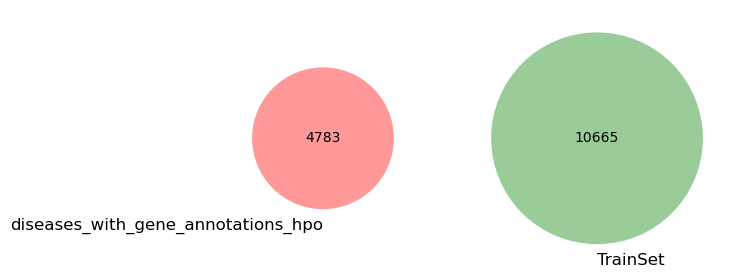

In [10]:
pltv.venn2([diseases_annotated_genes_hpo,diseases_train],['diseases_with_gene_annotations_hpo','TrainSet'])

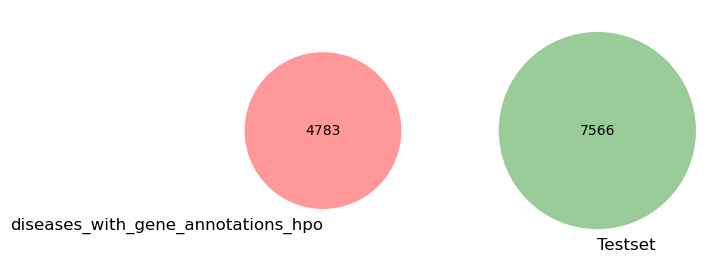

In [11]:
pltv.venn2([diseases_annotated_genes_hpo,diseases_test],['diseases_with_gene_annotations_hpo','Testset'])

# common diseases between phenotype to disease file and training and test set

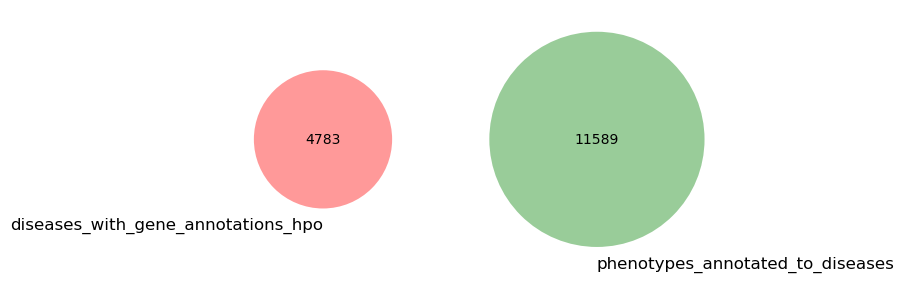

In [12]:
pltv.venn2([diseases_annotated_genes_hpo,phen_pd2_files_dis],['diseases_with_gene_annotations_hpo','phenotypes_annotated_to_diseases'])

# HOW DIFFERENT ARE THE DISEASES IN DISGENET

In this part of the notebook we will investigate the diseases in DisGeNET, we will then remove diseases that have more than 20 associations of which 90% are in common

In [21]:
disgenet = pd.read_csv('../../datasets/curated_gene_disease_associations.tsv',sep='\t')
di = disgenet[disgenet.diseaseName.str.contains('Alzheimer')]
di.head()

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
2,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998.0,2018.0,3,0,CTD_human
18,2,A2M,0.529,0.769,C0276496,Familial Alzheimer Disease (FAD),disease,C10;F03,Disease or Syndrome,0.31,1.000,1998.0,2016.0,3,0,CTD_human
19,2,A2M,0.529,0.769,C0494463,"Alzheimer Disease, Late Onset",disease,C10;F03,Mental or Behavioral Dysfunction,0.37,0.800,1998.0,2010.0,3,0,CTD_human
21,2,A2M,0.529,0.769,C0750900,"Alzheimer's Disease, Focal Onset",disease,C10;F03,Mental or Behavioral Dysfunction,0.30,1.000,1998.0,2004.0,3,0,CTD_human
22,2,A2M,0.529,0.769,C0750901,"Alzheimer Disease, Early Onset",disease,C10;F03,Disease or Syndrome,0.30,1.000,1998.0,2004.0,3,0,CTD_human


In [22]:
for dis in di.diseaseId.value_counts().index:
    print(dis,di[di.diseaseId == dis].geneId.tolist())

C0002395 [2, 43, 102, 267, 274, 341, 348, 351, 498, 581, 590, 596, 627, 801, 836, 945, 1139, 1141, 1191, 1200, 1378, 1392, 1471, 1565, 1636, 1718, 1808, 1965, 2023, 2041, 2099, 2147, 2932, 3077, 3127, 3162, 3416, 3479, 3480, 3481, 3482, 3553, 3630, 3635, 3643, 3952, 4129, 4137, 4353, 4524, 4846, 4852, 5328, 5336, 5468, 5621, 5649, 5663, 5664, 5697, 5819, 6517, 6648, 6653, 7018, 7019, 7124, 7167, 7422, 7447, 7782, 8301, 8633, 9510, 10347, 10452, 10857, 10858, 23237, 23385, 23607, 23621, 26330, 27328, 51225, 51338, 51741, 54209, 55676, 57091, 124152, 406892, 406938, 407022, 494324, 574508, 768218, 100126333, 100170222, 100500871, 100616367]
C0276496 [2, 43, 102, 267, 274, 341, 348, 351, 498, 581, 590, 596, 627, 801, 836, 945, 1139, 1141, 1191, 1200, 1378, 1392, 1471, 1565, 1636, 1718, 1808, 1965, 2023, 2041, 2099, 2147, 2932, 3077, 3127, 3162, 3416, 3479, 3480, 3481, 3482, 3553, 3630, 3635, 3643, 3952, 4129, 4137, 4353, 4524, 4846, 4852, 5328, 5336, 5468, 5621, 5649, 5663, 5664, 5697, 58

# 3. Erase disease with more than 30 associations with similarity above 90%

In [23]:
disgenet_grouped = disgenet.groupby('diseaseId').agg({'geneId':list,'diseaseName':'first'})
disgenet_grouped.head()

,geneId,diseaseName
diseaseId,,
C0000737,[3440],Abdominal Pain
C0000744,[4547],Abetalipoproteinemia
C0000768,"[156, 1295, 1317, 2138, 2332, 2348, 4851, 6299...",Congenital Abnormality
C0000771,"[387, 847, 2052, 7481, 51185]","Abnormalities, Drug-Induced"
C0000772,"[406, 1055, 1147, 1499, 2263, 2852, 2932, 5424...",Multiple congenital anomalies


# Mean number of association

In [24]:
disgenet_grouped['nofassociations'] = disgenet_grouped['geneId'].apply(lambda x: len(x))

In [25]:
diseases = disgenet_grouped.index.tolist()
nofassociations = 20
for disease in diseases:
    try:
        #if we cannot find the diseases means it has been dropped
        associations = disgenet_grouped[disgenet_grouped.index == disease].geneId.tolist()[0]
        if len(associations) >= nofassociations:
            for ix,ass,dis in zip(range(disgenet_grouped.shape[0]),disgenet_grouped.geneId.tolist(),disgenet_grouped.index.tolist()): #checking all the other associations
                if ((dis != disease)&(len(set(associations).intersection(set(ass))) > 0.90*nofassociations)):
                    disgenet_grouped = disgenet_grouped.drop(dis)
                    print('dropped',dis)
    except Exception as e:
        print(e)
            
    

dropped C0000822
dropped C0023893
dropped C3830362
dropped C4552766
list index out of range
dropped C0006142
dropped C0006826
dropped C0007097
dropped C0007102
dropped C0007131
dropped C0007137
dropped C0009375
dropped C0009402
dropped C0009404
dropped C0014859
dropped C0024121
dropped C0024623
dropped C0024668
dropped C0027627
dropped C0030297
dropped C0033578
dropped C0035126
dropped C0036341
dropped C0038356
dropped C0205641
dropped C0205642
dropped C0205643
dropped C0205644
dropped C0205645
dropped C0205696
dropped C0205697
dropped C0205698
dropped C0205699
dropped C0242379
dropped C0279702
dropped C0346647
dropped C0376358
dropped C0546837
dropped C0678222
dropped C0919267
dropped C1140680
dropped C1257931
dropped C1458155
dropped C1708349
dropped C2239176
dropped C4704874
dropped C0205646
dropped C0205647
dropped C0205648
dropped C0205649
dropped C0205650
dropped C0205651
dropped C0029456
dropped C0029459
dropped C0751406
dropped C0001973
dropped C0085762
list index out of range


In [26]:
di2 = disgenet_grouped.explode('geneId')
d = di2[di2.diseaseName.str.contains("Alzheimer")]
for dis in d.index.value_counts().index:
    print(dis,d[d.index == dis].geneId.tolist())

C0002395 [2, 43, 102, 267, 274, 341, 348, 351, 498, 581, 590, 596, 627, 801, 836, 945, 1139, 1141, 1191, 1200, 1378, 1392, 1471, 1565, 1636, 1718, 1808, 1965, 2023, 2041, 2099, 2147, 2932, 3077, 3127, 3162, 3416, 3479, 3480, 3481, 3482, 3553, 3630, 3635, 3643, 3952, 4129, 4137, 4353, 4524, 4846, 4852, 5328, 5336, 5468, 5621, 5649, 5663, 5664, 5697, 5819, 6517, 6648, 6653, 7018, 7019, 7124, 7167, 7422, 7447, 7782, 8301, 8633, 9510, 10347, 10452, 10857, 10858, 23237, 23385, 23607, 23621, 26330, 27328, 51225, 51338, 51741, 54209, 55676, 57091, 124152, 406892, 406938, 407022, 494324, 574508, 768218, 100126333, 100170222, 100500871, 100616367]
C1837149 [10347]
C1843013 [5663]
C1843015 [5663]
C4303482 [5621]
